# Score Evaluation Demo
- User Story  
I am a data scientist and I've built a model to predict the stock price. I have my test data set and trained model, but I need evaluate if this model performance as well as expected. 
- Solution  
I installed score-eval package and run evaluation on my data set plus the model. I would like to evaluate in couple of metrics. 
1. The overall performance. I would like to check the PR chart and WOE/IV chart. Here I put some background on those two chart, please skip if you are familiar with them. 
    1. PR chart. The x-axis is 'recall' and the y-axis is 'precision'. When we try to achieve higher precision we usually lose certain recall and vice versa. It is quite difficult to achieve perfect classification so we have to trade off. PR chart shows the balance between the two metrics and we can compare how multiple models performs by this way. 
    2. WOE/IV chart. The x-axis is 'score bins' and the y-axis is 'WOE'. It is a statistical method to check how the 1-samples and 0-samples are separated in the bin. In most real-world cases, we adopt a machine learning model only at the highest and lowest score bins. We do not adopt the middle 'grey' part, which is not safe for follow-up decisions. WOE/IV chart is quite intuitive tool letting us understand the performance in score bins. 

2. The score cutoff performance. If we still need more details to decide which model or which cutoff is a good choice, I suggest to look into the op/cutoff charts.Here I put some backgound on OP and Cutoff, please skip if you are familiar with them. 
    1. OP(Operating Point). This is quite straightforward, it is saying how many proportion of the population can be operating. It is usually calculated by percent, from high to low. eg. OP 10 means the 10% samples with the highest score in your data set. 
    2. Cut-off. This is not calculated by percent but by the score value itself. Assuming the score is in interval, the cut-off can be 0.1, 0.2, ... 0.9 etc. 

3. Metrics along time. In real cases, the samples come up from time to time, but the evaluation data set is usually static. The above methods are doing the evaluation as a whole. It is also necessary to check the metrics by time(time-step, can be days, weeks, hours etc.).

**Install**

In [35]:
!pip install score-eval

You should consider upgrading via the 'd:\python\python37\python.exe -m pip install --upgrade pip' command.


In [39]:
from scoreval import scoreval as se

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [37]:
# Set path parameters, this is only applicable in this example and you can set it as you wish
BASE_DIR = "E:\\workspace\\stock"
RUN_DATE = '20220304' # str(datetime.now())[:10].replace('-','')

# Load test data
DATA_DIR = os.path.join(BASE_DIR,'data', RUN_DATE) # path to save processed data files

# Load model file
MODEL_DIR = os.path.join(BASE_DIR,'python/tf/models') # path where the model spec is located


**Load data set**  
My data set is saved in a npz file. This is none of the matters for ScoreEval, but relevant with the model implementation. 

In [15]:
with open(os.path.join(DATA_DIR, 'oot-xl.npz'), 'rb') as fp:
    oot_data = np.load(fp)
    oot_X_arr, oot_S_arr, oot_P_arr, oot_I_arr, oot_Y_arr, oot_R_arr = oot_data['x'], oot_data['s'], oot_data['p'],oot_data['i'],oot_data['y'],oot_data['r']

In [40]:
# Make my data set as a pandas DataFrame, this is required by ScoreEval
df_y = pd.DataFrame(np.concatenate([oot_Y_arr, oot_R_arr],axis=1))
df_y.columns=['label', 'symbol', 'date']
df_y['label'] = df_y['label'].astype(np.float16).astype(np.int16)
df_y.head()


,label,symbol,date
0,0,SH603198,2021-11-02
1,0,SH603198,2021-06-17
2,0,SH603198,2021-07-20
3,0,SH600436,2021-07-01
4,0,SH600436,2021-03-10


**Load model**  
My model is implemented by tensorflow keras, which is quite a flexible and popular tool for neural networks. 

In [38]:
models = []
models.append(
   tf.keras.models.load_model(os.path.join(MODEL_DIR,'./XL-L60D64L32FC16BN-v1.h5'))
)


**Create ScoreEval Object**  
A list of model objects can be an initializer for the ScoreEval object. In the next steps, SE will always use all the models in this list. 

In [41]:
# Create ScoreEval object, initialized by a list of model objects
se_oot = se.ScoreEval(models)

In [42]:
# Run score, make sure the models have the same inputs. SE will call model.predict for each model. 
# That is not a good idea to take models with different inputs. Please always compare apple to apple. 
# Make sure X and Y have the same rows so that the score can be produced properly. 
se_oot.run_score([oot_X_arr,oot_S_arr,oot_P_arr,oot_I_arr,], df_y)

# Calculate precision/recall metrics by OP/Cutoff
se_oot.score_cut()

**Plotting**  
We will look into the 3 types of charts and understand the model performance well. I just show the methods here but leave the conlusion out. 

*Part 1* Overview

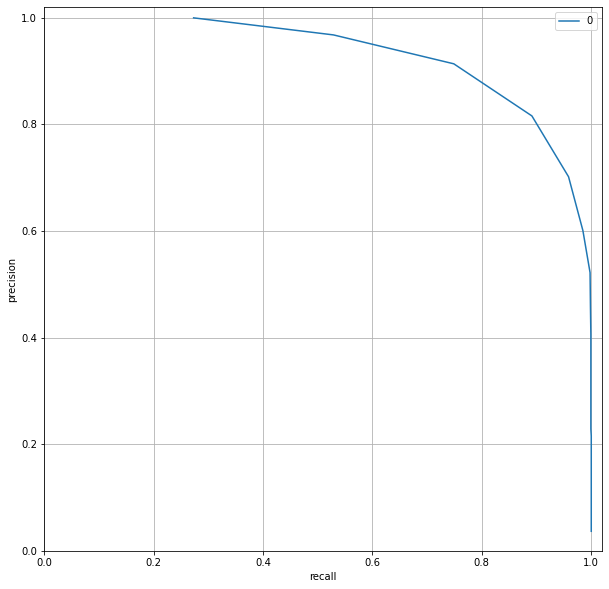

In [43]:
# Plot PR chart: it is better if the curve is reaching to the right upper corner. 
se_oot.plot_pr()

D:\Python\Python37\lib\site-packages\scoreval\scoreval.py:306: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_final_2['binbd'])


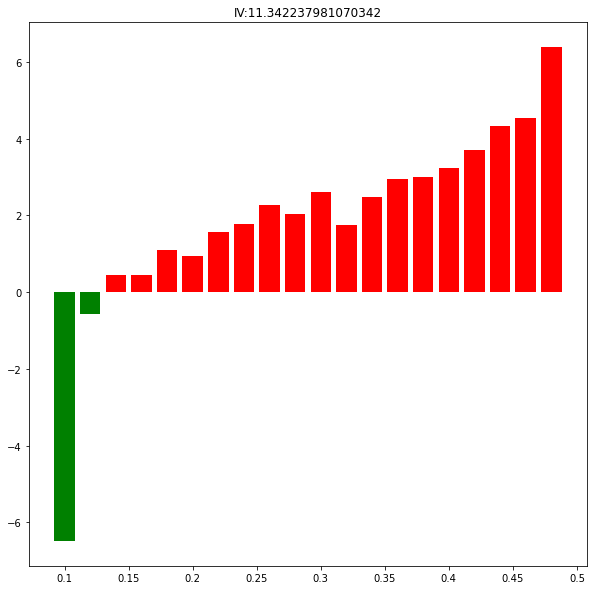

In [45]:
# WOE/IV chart: it is better if the bars' height is large at low and high bins, which is called 'indicative power'. 
# IV, in the chart title, is a weighed average of all bins, and it is better if larger.
se_oot.iv()

*Part 2 Breakdown by score*

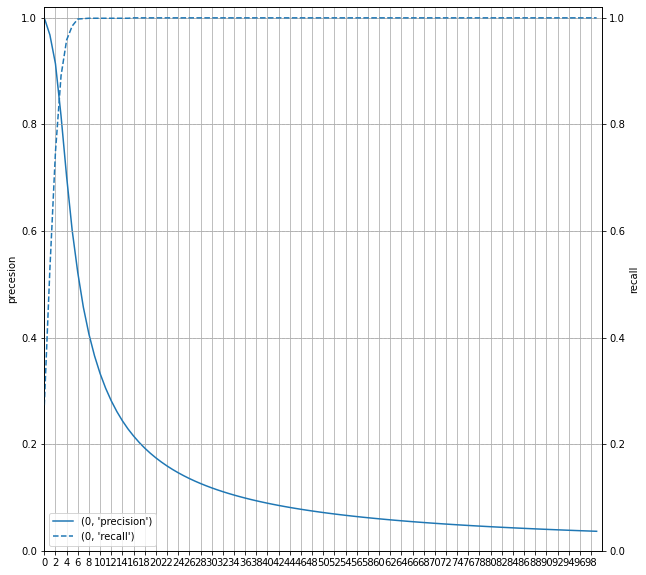

In [46]:
# OP chart.
se_oot.plot_op_chart()

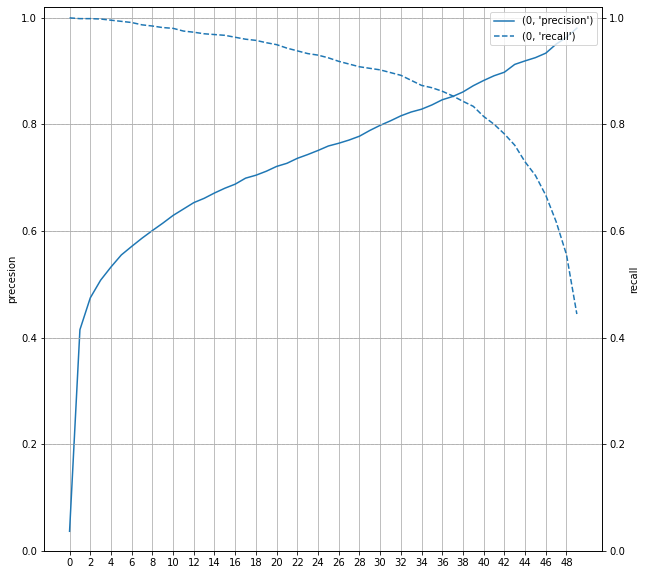

In [47]:
# Cutoff chart
se_oot.plot_cutoff_chart()

*Part 3 Breakdown by timestep*

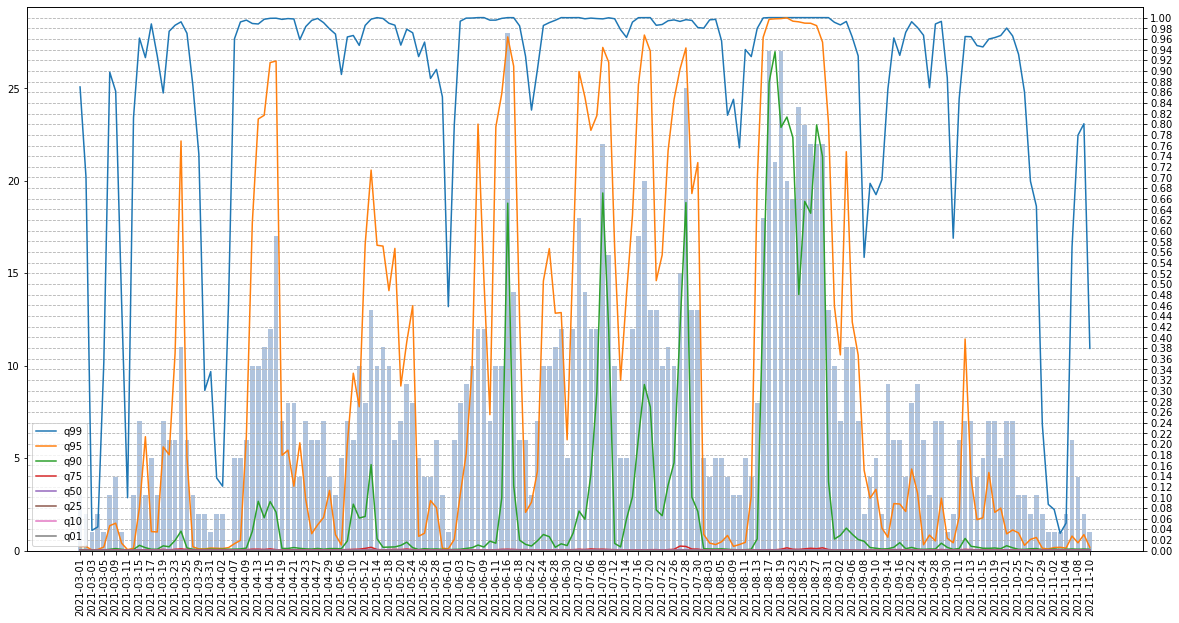

In [52]:
# The bar is how many 1-samples in that day. The lines is score quantiles in that day. 
# eg. q99 means the score value where 99% samples are less than it. 
se_oot.daily_qtls(figsize=(20,10))

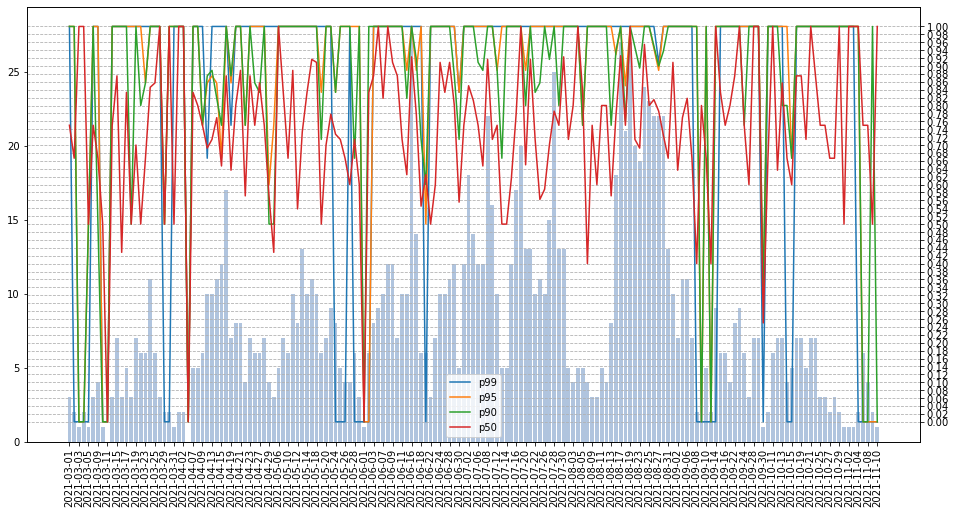

In [50]:
# The bar is how many 1-samples in that day. The lines is the precision in that day by different cutoff, shown in the legend. 
# eg. p99 means precision at cutoff score>0.99
se_oot.daily_precision()

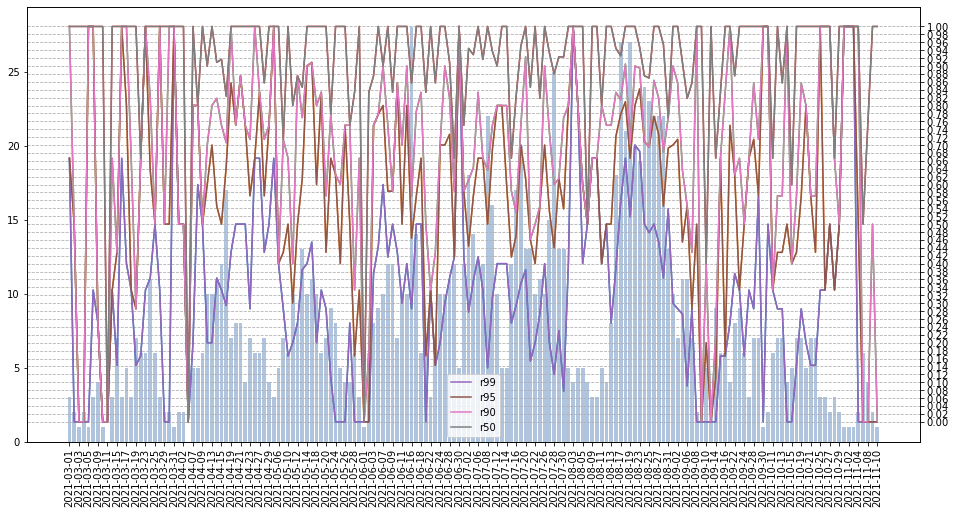

In [51]:
se_oot.daily_recall()

**Quiz**  
Do you think this is a good model?